In [8]:
import cvxpy as cvx
import matplotlib.pyplot as plt
# See Rockefeller cahpter what have you
# in haskell these would be effectful lens a -> m (b, b -> m a)
class ConvexCat():
    def __init__(self,res):
        self.res = res
    def idd(n):
        def res():
            x = cvx.Variable(n)
            return x, x, 0, []
        return ConvexCat(res)
    def par(f,g):
        def res():
            x,y,o1, c1 = f()
            z,w,o2, c2 = g()
            a = cvx.hstack((x,z)) 
            b = cvx.hstack((y,w))
            return a , b , o1 + o2, c1 + c2 + [a == a, b == b] # sigh. Don't ask. Alright. FINE. cvxpyp needs hstacks registered to populate them with values
        return ConvexCat(res)
    def compose(g,f):
        def res():
            x,y,o1, c1 = f()
            y1,z,o2, c2 = g()
            return x , z, o1 + o2, c1 + c2 + [y == y1]
        return ConvexCat(res)
    def dup(n):
        def res():
           x = cvx.Variable(n)
           return x, cvx.vstack(x,x) , 0, []
        return ConvexCat(res)
    def __call__(self):
        return self.res()
    def run(self):
        x, y, o, c = self.res()
        prob = cvx.Problem(cvx.Minimize(o),c)
        sol = prob.solve()
        return sol, x, y, o
    def __matmul__(self,g):
        return self.compose(g)
    def __mul__(self,g):
        return self.par(g)
    def const(v):
        def res():
            x = cvx.Variable(1) # hmm. cvxpy doesn't like 0d variables. That's too bad
            return x, x, 0, [x == v]
        return ConvexCat(res)
    def converse(f):
        def res():
            a,b,o,c = f()
            return b, a, o, c
        return ConvexCat(res)
    def add(n):
        def res():
            x = cvx.Variable(n)
            return x, cvx.sum(x), 0, []
        return ConvexCat(res)
    def smul(s,n):
        def res():
            x = cvx.Variable(n)
            return x, s * x, 0, []
        return ConvexCat(res)
    def pos(n):
        def res():
            x = cvx.Variable(n, positive=True)
            return x, x, 0 , []
        return ConvexCat(res)
        

         
    
    

In [10]:
def controller(Cat,pend_step, pos, vel):
   acc = Cat.idd(3)
   for i in range(10):
      acc = acc @ pend_step
   init = Cat.const(pos) * Cat.const(vel) * Cat.idd(1) 
   return acc @ init

-1.0000000000000002
-1.0000000000000002
-1.0000000000000002
-1.0000000000000002
-1.0
-1.0
-1.0
-1.0
-1.0
0.06294979496382455
0.6775189061641425
0.55890912857367
0.4548078653862694
0.37002045409361767
0.30103857698835573
0.2449167866102856
0.19925762645178774
0.1621105774262547
0.13188875016449217
0.10730109469793651
0.08729724793824986
0.07102266308694817
0.0577821041452555
0.04700994604167024
0.03824601162472913
0.03111591329848172
0.02531505951257438
0.020595642878219904
0.016756054053772743
0.01363226917038198


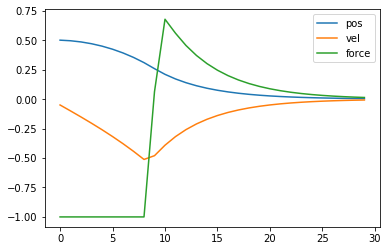

In [21]:
CC = ConvexCat
idd = CC.idd
f = CC.const(1) @ (idd(5) * idd(6))
sol, x, y, o = f.run()


def pend_step_res():
    dt = 0.1
    x = cvx.Variable(2)
    xnext = cvx.Variable(2)
    f = cvx.Variable(1)
    
    pos = x[0]
    vel = x[1]
    posnext = xnext[0]
    velnext = xnext[1]
    c = []
    c += [posnext == pos + vel*dt] # position update
    c += [velnext == vel + (pos + f )* dt] # velocity update
    c += [-1 <= f, f <= 1] # force constraint
    c += [-1 <= posnext,   posnext <= 1] # safety constraint
    c += [-1 <= pos, pos <= 1]
    obj = pos**2 + posnext**2 # + 0.1 * f**2
    z = cvx.Variable(1)
    c += [z == 0]
    return cvx.hstack((x , f)) , cvx.hstack((xnext,z)), obj,  c

pend_step = ConvexCat(pend_step_res)

pos = 0.5
vel = 0
poss = []
vels = []
fs = []
dt = 0.1
'''
p_pos = cvx.Param(1)
p_vel = cvx.Param(1)
p_pos.value = pos
p_pos.value = pos
'''
for j in range(30):

   prob = controller(ConvexCat, pend_step, pos, vel)
   _, x ,y ,_ = prob.run()
   print(x.value[2])
   #print(dir(x))
   f = x.value[2]
   #print(f)
   
   # actually update the state 
   pos = pos + vel * dt
   vel = vel + (pos + f )* dt
   poss.append(pos)
   vels.append(vel)
   fs.append(f)
plt.plot(poss,label="pos")
plt.plot(vels, label="vel")
plt.plot(fs, label="force")
plt.legend()
plt.savefig("controllerplot")
   
   

In [2]:
from graphcat import *

In [20]:
GC = GraphCat
pend_step = GC.block("pend_step", ["x(t)", "v(t)", "f(t)"],["x(t+1)", "v(t+1)", "f(t+1)"])
pos = 0.5
vel = 0
'''
acc = GC.idd(3)
for i in range(10):
  acc = acc @ pend_step
init = GC.const(pos) * GC.const(vel) * GC.idd(1) 
prob = acc @ init
'''
prob = controller(GraphCat, pend_step, pos, vel)
x = prob.run()
x.format = "png"
x.render("controller")

'controller.png'

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 23)